# Exercise 1 

# Question 1 

In [1]:
import pandas as pd
import numpy as np
from sklearn.covariance import LedoitWolf  

In [2]:
RX = pd.read_excel("../data/Factors_Net.xlsx", sheet_name='All')
RX["date"] = pd.to_datetime(RX["date"], format="%Y%m%d")
RX = RX.set_index("date")
RX = RX.iloc[1:]
RX.head()

,DOL,CDOL,CAR,VAL,M1M,M3M,M6M,M1Y,VOL,SKEW,KURT
date,,,,,,,,,,,
1976-02-27,-0.006629,-0.006629,-0.058770,0.003982,0.040807,0.014140,0.014140,0.007180,0.003880,-0.003946,0.003817
1976-03-31,-0.011215,-0.011215,-0.042299,-0.074420,0.029744,0.030005,0.030005,0.030005,-0.067788,-0.040506,-0.051597
1976-04-30,-0.002435,-0.002435,-0.023935,-0.046766,0.030610,0.038017,0.038017,0.038017,-0.028100,-0.024332,-0.028213
1976-05-28,-0.007553,-0.007553,0.030442,0.027891,-0.023556,-0.021808,-0.021735,-0.021735,0.042642,0.057087,0.056599
1976-06-30,0.002889,0.002889,0.009257,0.018576,-0.006100,-0.017402,-0.012873,-0.012873,0.003532,0.004137,-0.001002


In [3]:
window = 36
sigma = 0.1
sigma_monthly = sigma / np.sqrt(12)

## 1N

In [4]:
#Raw weights
N = RX.shape[1]
weights = np.ones(N) / N

X_past = RX.iloc[:window].to_numpy()
Sigma = LedoitWolf().fit(X_past).covariance_

In [5]:
# portfolio monthly variance from raw weights:
port_var = float(weights.T @ Sigma @ weights)
port_vol = np.sqrt(port_var)

# rescaling factor:
scale = sigma_monthly / port_vol

# final weights w_t:
w = scale * weights

In [6]:
next_month_returns = RX.iloc[window].to_numpy()
RX_star = float(w @ next_month_returns)
RX_star

-0.002232272991767351

In [7]:
def combined_1N_appendixE(RX, init_window=36, sigma_star_annual=0.10):
    sigma_star_monthly = sigma_star_annual / np.sqrt(12)

    T, N = RX.shape
    combined = np.full(T, np.nan)

    for t in range(init_window, T):
        # 1) expanding window up to t-1
        X_past = RX.iloc[:t].to_numpy()

        # 2) raw weights omega = 1/N
        omega = np.ones(N) / N

        # 3) Ledoit-Wolf Sigma_t
        Sigma = LedoitWolf().fit(X_past).covariance_

        # 4) rescale to target vol
        port_vol = np.sqrt(float(omega.T @ Sigma @ omega))
        w = (sigma_star_monthly / port_vol) * omega

        # 5) combined return at time t
        combined[t] = float(w @ RX.iloc[t].to_numpy())
    
    print(omega)
    print(w)
    return pd.Series(combined, index=RX.index, name="Combined_1N")

R_comb_1N = combined_1N_appendixE(RX)
R_comb_1N.dropna().tail()

[0.09090909 0.09090909 0.09090909 0.09090909 0.09090909 0.09090909
 0.09090909 0.09090909 0.09090909 0.09090909 0.09090909]
[0.26907539 0.26907539 0.26907539 0.26907539 0.26907539 0.26907539
 0.26907539 0.26907539 0.26907539 0.26907539 0.26907539]


date
2025-09-30    0.025252
2025-10-31    0.061027
2025-11-28    0.022248
2025-12-31    0.013598
2026-01-30    0.042630
Name: Combined_1N, dtype: float64

## MEAN

In [8]:
import numpy as np
import pandas as pd
from sklearn.covariance import LedoitWolf

def combined_MEAN(RX, init_window=36, sigma_star_annual=0.10):
    RX = RX.dropna(how="all").copy()
    T, N = RX.shape

    sigma_star_monthly = sigma_star_annual / np.sqrt(12.0)
    combined = np.full(T, np.nan)

    for t in range(init_window, T):
        # 1) use past data only (up to t-1)
        X_past = RX.iloc[:t].to_numpy(dtype=float)

        # 2) expected returns (historical mean)
        mu = np.nanmean(X_past, axis=0)

        # 3) MEAN raw weights omega
        denom = float(np.sum(mu))
        if np.abs(denom) > 1e-12:
            omega = mu / denom
        else:
            omega = np.ones(N) / N  # fallback if sum(mu)=0

        # 4) Ledoit–Wolf covariance for scaling (drop rows with NaNs)
        mask = np.isfinite(X_past).all(axis=1)
        X_cov = X_past[mask, :]
        if X_cov.shape[0] < 5:
            Sigma = np.cov(np.nan_to_num(X_past), rowvar=False)
        else:
            Sigma = LedoitWolf().fit(X_cov).covariance_

        # 5) scale ex-ante to 10% annual volatility
        port_var = float(omega.T @ Sigma @ omega)
        if port_var > 0 and np.isfinite(port_var):
            w = (sigma_star_monthly / np.sqrt(port_var)) * omega
        else:
            w = np.ones(N) / N

        # 6) realized combined return at time t
        combined[t] = float(w @ RX.iloc[t].to_numpy(dtype=float))

    return pd.Series(combined, index=RX.index, name="Mean")

In [9]:
R_MEAN = combined_MEAN(RX)
R_MEAN.dropna().head()

date
1979-02-28   -0.007472
1979-03-30   -0.034035
1979-04-30   -0.027379
1979-05-31   -0.000785
1979-06-29    0.014121
Name: Mean, dtype: float64

## VOL

In [10]:
# 1) Raw weight rules (omega_t)
# ----------------------------
def raw_weights(mu: np.ndarray, sd: np.ndarray, method: str) -> np.ndarray:
    """
    Returns raw weights omega_t for Appendix E methods (except MINVAR/MAXRET).
    mu, sd computed using data up to t-1 (expanding window).
    """
    method = method.upper()
    N = len(mu)

    if method == "1N":
        return np.ones(N) / N

    if method == "MEAN":
        denom = np.sum(mu)
        return (mu / denom) if np.abs(denom) > 1e-12 else np.ones(N) / N

    if method == "VOL":
        inv_sd = np.where(sd > 0, 1.0 / sd, 0.0)
        denom = np.sum(inv_sd)
        return (inv_sd / denom) if denom > 0 else np.ones(N) / N

    if method == "SR":
        SR = np.where(sd > 0, mu / sd, 0.0)
        denom = np.sum(SR)
        return (SR / denom) if np.abs(denom) > 1e-12 else np.ones(N) / N

    if method == "TOP3":
        SR = np.where(sd > 0, mu / sd, -np.inf)
        top_idx = np.argsort(SR)[::-1][:min(3, N)]
        omega = np.zeros(N)
        denom = np.sum(SR[top_idx])
        if np.isfinite(denom) and np.abs(denom) > 1e-12:
            omega[top_idx] = SR[top_idx] / denom
        else:
            omega[top_idx] = 1.0 / len(top_idx)
        return omega

    raise ValueError(f"Unknown method for raw_weights: {method}")

In [11]:
def combined_VOL(RX, init_window=36):
    RX = RX.dropna(how="all")  # remove all-NaN rows
    T, N = RX.shape

    sigma_star_monthly = 0.10 / np.sqrt(12)
    combined = np.full(T, np.nan)

    for t in range(init_window, T):
        X_past = RX.iloc[:t].to_numpy()

        # 1) volatility per strategy
        sd = X_past.std(axis=0, ddof=1)

        # 2) raw VOL weights omega
        inv_sd = 1 / sd
        omega = inv_sd / inv_sd.sum()

        # 3) Ledoit–Wolf covariance
        Sigma = LedoitWolf().fit(X_past).covariance_

        # 4) rescale to target vol
        port_vol = np.sqrt(float(omega.T @ Sigma @ omega))
        w = (sigma_star_monthly / port_vol) * omega

        # 5) combined return at time t
        combined[t] = float(w @ RX.iloc[t].to_numpy())

    return pd.Series(combined, index=RX.index, name="Combined_VOL")

In [12]:
R_vol = combined_VOL(RX)
R_vol.dropna().head()

date
1979-02-28   -0.001432
1979-03-30    0.018465
1979-04-30    0.032660
1979-05-31    0.002223
1979-06-29    0.007081
Name: Combined_VOL, dtype: float64

## SR Method

In [13]:
def combined_SR(RX, init_window=36):
    RX = RX.dropna(how="all")  # remove all-NaN rows
    T, N = RX.shape

    sigma_star_monthly = 0.10 / np.sqrt(12)
    combined = np.full(T, np.nan)

    for t in range(init_window, T):
        X_past = RX.iloc[:t].to_numpy()

        # 1) volatility per strategy
        mu = X_past.mean(axis=0)
        sd = X_past.std(axis=0, ddof=1)

        # 2) raw SR weights omega
        SR = mu/sd
        omega = SR / SR.sum()

        # 3) Ledoit–Wolf covariance
        Sigma = LedoitWolf().fit(X_past).covariance_

        # 4) rescale to target vol
        port_vol = np.sqrt(float(omega.T @ Sigma @ omega))
        w = (sigma_star_monthly / port_vol) * omega

        # 5) combined return at time t
        combined[t] = float(w @ RX.iloc[t].to_numpy())

    return pd.Series(combined, index=RX.index, name="Combined_VOL")

In [14]:
R_SR = combined_SR(RX)
R_SR.dropna().head()

date
1979-02-28   -0.007636
1979-03-30   -0.035282
1979-04-30    0.028983
1979-05-31   -0.000779
1979-06-29    0.013328
Name: Combined_VOL, dtype: float64

## Top 3 Method

In [15]:
def combined_top3(RX, init_window=36):
    RX = RX.dropna(how="all")  # remove all-NaN rows
    T, N = RX.shape

    sigma_star_monthly = 0.10 / np.sqrt(12)
    combined = np.full(T, np.nan)

    for t in range(init_window, T):
        X_past = RX.iloc[:t].to_numpy()

        # 1) volatility per strategy
        mu = X_past.mean(axis=0)
        sd = X_past.std(axis=0, ddof=1)
        SR = mu/sd

        # 2) raw top3 weights omega
        
        top_idx = np.argsort(SR)[::-1][:3]
        omega = np.zeros_like(SR)
        omega[top_idx] = SR[top_idx] / SR[top_idx].sum()

        # 3) Ledoit–Wolf covariance
        Sigma = LedoitWolf().fit(X_past).covariance_

        # 4) rescale to target vol
        port_vol = np.sqrt(float(omega.T @ Sigma @ omega))
        w = (sigma_star_monthly / port_vol) * omega

        # 5) combined return at time t
        combined[t] = float(w @ RX.iloc[t].to_numpy())

    return pd.Series(combined, index=RX.index, name="Combined_VOL")

In [16]:
R_Top3 = combined_top3(RX)
R_Top3.dropna().head()

date
1979-02-28    0.010611
1979-03-30    0.035372
1979-04-30    0.034833
1979-05-31    0.001911
1979-06-29   -0.007222
Name: Combined_VOL, dtype: float64

## MaxRet

In [17]:
import numpy as np
import pandas as pd
from sklearn.covariance import LedoitWolf

def combined_MaxRet(RX, init_window=36, sigma_star_annual=0.10):
    """
    MaxRet: maximize w' mu subject to:
      (1) 1' w = 1
      (2) w' Sigma w = (sigma_star_monthly)^2
    Expanding window, monthly rebalancing, Sigma estimated by LedoitWolf.
    """
    RX = RX.dropna(how="all").copy()
    T, N = RX.shape

    sigma_star_monthly = sigma_star_annual / np.sqrt(12.0)
    target_var = float(sigma_star_monthly**2)

    combined = np.full(T, np.nan)
    ones = np.ones(N)

    for t in range(init_window, T):
        # Past data (up to t-1)
        X_past = RX.iloc[:t].to_numpy(dtype=float)

        # Mean vector mu (historical mean, expanding window)
        mu = np.nanmean(X_past, axis=0)

        # Ledoit–Wolf covariance needs complete rows
        mask = np.isfinite(X_past).all(axis=1)
        X_cov = X_past[mask, :]
        if X_cov.shape[0] < 5:
            # fallback if too few clean rows
            Sigma = np.cov(np.nan_to_num(X_past), rowvar=False)
        else:
            Sigma = LedoitWolf().fit(X_cov).covariance_

        Sinv = np.linalg.pinv(Sigma)

        # Scalars
        A = float(ones @ Sinv @ ones)
        B = float(ones @ Sinv @ mu)
        C = float(mu   @ Sinv @ mu)
        c = target_var

        # Solve for gamma using the variance constraint -> quadratic
        # Derived from the constrained MV solution with 1'w=1 and w'Σw=c
        a2 = A * (1.0 - c * A)
        b2 = -2.0 * B * (1.0 - c * A)
        c2 = C - c * (B**2)

        disc = b2*b2 - 4.0*a2*c2

        def make_feasible(w):
            """Enforce sum-to-1 and hit variance target (numerical safety)."""
            s = np.sum(w)
            if np.abs(s) > 1e-12:
                w = w / s
            var = float(w @ Sigma @ w)
            if var > 0 and np.isfinite(var):
                w = (sigma_star_monthly / np.sqrt(var)) * w
                # re-enforce sum-to-1 after scaling (tiny drift)
                s2 = np.sum(w)
                if np.abs(s2) > 1e-12:
                    w = w / s2
            return w

        if disc < 0 or np.abs(a2) < 1e-14:
            # fallback: use MinVar direction then scale
            w = (Sinv @ ones) / float(ones @ Sinv @ ones)
            w = make_feasible(w)
        else:
            g1 = (-b2 + np.sqrt(disc)) / (2.0 * a2)
            g2 = (-b2 - np.sqrt(disc)) / (2.0 * a2)

            def w_from_g(g):
                lam = (B - g * A)
                if np.abs(lam) < 1e-14:
                    return np.ones(N) / N
                w = (1.0 / lam) * (Sinv @ (mu - g * ones))
                return w

            w1 = make_feasible(w_from_g(g1))
            w2 = make_feasible(w_from_g(g2))

            # Choose the one with higher expected return
            w = w1 if float(w1 @ mu) >= float(w2 @ mu) else w2

        # Realized combined return at time t
        combined[t] = float(w @ RX.iloc[t].to_numpy(dtype=float))

    return pd.Series(combined, index=RX.index, name="MaxRet")

In [18]:
R_MaxRet = combined_MaxRet(RX)
R_MaxRet.dropna().head()

date
1979-02-28    0.012065
1979-03-30    0.050912
1979-04-30    0.040685
1979-05-31   -0.005092
1979-06-29    0.006527
Name: MaxRet, dtype: float64

## MinVar

In [19]:
import numpy as np
import pandas as pd
from sklearn.covariance import LedoitWolf

def combined_MinVar(RX, init_window=36, sigma_star_annual=0.10):
    RX = RX.dropna(how="all").copy()
    T, N = RX.shape

    sigma_star_monthly = sigma_star_annual / np.sqrt(12.0)
    combined = np.full(T, np.nan)

    ones = np.ones(N)

    for t in range(init_window, T):
        # 1) use past data only (up to t-1)
        X_past = RX.iloc[:t].to_numpy(dtype=float)

        # 2) Ledoit–Wolf covariance (drop rows with NaNs)
        mask = np.isfinite(X_past).all(axis=1)
        X_cov = X_past[mask, :]

        if X_cov.shape[0] < 5:
            # fallback if too few complete observations
            Sigma = np.cov(np.nan_to_num(X_past), rowvar=False)
        else:
            Sigma = LedoitWolf().fit(X_cov).covariance_

        # 3) MinVar raw weights omega_t = Σ^{-1}1 / (1'Σ^{-1}1)
        Sinv = np.linalg.pinv(Sigma)
        denom = float(ones @ Sinv @ ones)
        omega = (Sinv @ ones) / denom if np.abs(denom) > 1e-12 else np.ones(N) / N

        # 4) Scale ex-ante to 10% annual volatility
        port_var = float(omega.T @ Sigma @ omega)
        if port_var > 0 and np.isfinite(port_var):
            w = (sigma_star_monthly / np.sqrt(port_var)) * omega
        else:
            w = np.ones(N) / N

        # 5) Realized combined return at time t
        combined[t] = float(w @ RX.iloc[t].to_numpy(dtype=float))

    return pd.Series(combined, index=RX.index, name="MinVar")

In [20]:
R_MinVar = combined_MinVar(RX)
R_MinVar.dropna().head()

date
1979-02-28   -0.002988
1979-03-30    0.018557
1979-04-30    0.038689
1979-05-31    0.002945
1979-06-29   -0.002944
Name: MinVar, dtype: float64

## Combined results

In [21]:
R_comb_1N.name = "Naive"
R_vol.name = "Volatility"
R_SR.name = "Sharpe Ratio"
R_Top3.name = "Top-3"
R_MEAN.name = "Mean"
R_MinVar.name = "Min Variance"
R_MaxRet.name = "Max Return"

all_results = pd.concat(
    [R_comb_1N, R_MEAN, R_vol, R_SR, R_Top3, R_MaxRet, R_MinVar],
    axis=1
)

all_results = all_results.dropna()
all_results.head()

,Naive,Mean,Volatility,Sharpe Ratio,Top-3,Max Return,Min Variance
date,,,,,,,
1979-02-28,-0.002232,-0.007472,-0.001432,-0.007636,0.010611,0.012065,-0.002988
1979-03-30,0.015845,-0.034035,0.018465,-0.035282,0.035372,0.050912,0.018557
1979-04-30,0.030837,-0.027379,0.032660,0.028983,0.034833,0.040685,0.038689
1979-05-31,0.001698,-0.000785,0.002223,-0.000779,0.001911,-0.005092,0.002945
1979-06-29,0.007769,0.014121,0.007081,0.013328,-0.007222,0.006527,-0.002944


In [22]:
import numpy as np
import pandas as pd

def summary_stats(r):
    
    mean_monthly = r.mean()
    vol_monthly = r.std()
    
    mean_ann = mean_monthly * 12
    vol_ann = vol_monthly * np.sqrt(12)
    
    sharpe = mean_ann / vol_ann
    
    downside = r[r < 0]
    sortino = mean_ann / (downside.std() * np.sqrt(12))
    
    return pd.Series({
        "Annualized Mean": mean_ann,
        "Annualized Volatility": vol_ann,
        "Sharpe Ration": sharpe,
        "Sortino Ratio": sortino
    })

In [23]:
all_results.apply(summary_stats).T


,Annualized Mean,Annualized Volatility,Sharpe Ration,Sortino Ratio
Naive,0.105573,0.106020,0.995785,1.423912
Mean,0.081530,0.093398,0.872928,1.395426
Volatility,0.106683,0.105801,1.008334,1.435269
Sharpe Ratio,0.090214,0.092913,0.970952,1.525686
Top-3,0.098019,0.101284,0.967768,1.453785
Max Return,0.101598,0.093184,1.090296,1.633378
Min Variance,0.091238,0.106450,0.857094,1.257043


## Combined Returns

In [24]:
import matplotlib.pyplot as plt

cum_returns = (1 + all_results).cumprod()

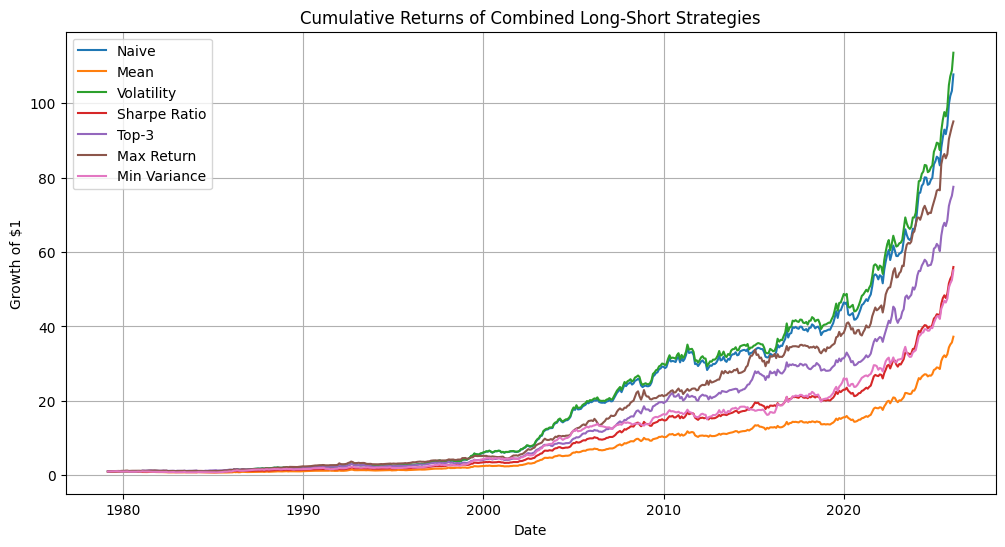

In [25]:
plt.figure(figsize=(12,6))

for col in cum_returns.columns:
    plt.plot(cum_returns.index, cum_returns[col], label=col)

plt.title("Cumulative Returns of Combined Long-Short Strategies")
plt.ylabel("Growth of $1")
plt.xlabel("Date")
plt.legend()
plt.grid(True)
plt.show()

# Question 2
Other way could be the exponentially-weighted sharpe combination. Instead of just using the simple hsitorical mean and sd we compute exponentially weighted mean and volatility so that recent performance matters more. 

In [26]:
import numpy as np
import pandas as pd
from sklearn.covariance import LedoitWolf
from scipy.optimize import minimize


def _downside_erc_objective(w: np.ndarray, cov_matrix: np.ndarray) -> float:
    """
    Fonction objectif : minimiser la variance des contributions au risque baissier.
    """
    port_var = w.T @ cov_matrix @ w
    if port_var <= 0:
        return 1e9

    port_vol = np.sqrt(port_var)
    # Contribution Marginale au Risque (MRC)
    mrc = (cov_matrix @ w) / port_vol
    # Contribution au Risque (RC)
    rc = w * mrc

    # Cible : chaque actif contribue de manière égale au risque
    target_rc = port_vol / len(w)

    # On minimise la somme des carrés des écarts par rapport à la cible
    return np.sum((rc - target_rc)**2)


def combined_downside_parity(
    RX: pd.DataFrame,
    init_window: int = 36,
    sigma_star_annual: float = 0.10,
    mar: float = 0.0  # Minimum Acceptable Return (0.0 par défaut)
) -> pd.Series:
    """
    Combinaison ex-ante : Downside Risk Parity -> vol target (10% p.a.)
    Utilise la semi-covariance de LedoitWolf pour dériver les poids ERC,
    et la covariance totale pour la mise à l'échelle finale.
    """
    RX = RX.dropna(how="all").copy()
    T, N = RX.shape

    sigma_star_monthly = sigma_star_annual / np.sqrt(12)
    combined = np.full(T, np.nan)

    # Contraintes et bornes pour l'optimisation (long-only, la somme des poids = 1)
    bounds = tuple((0.0, 1.0) for _ in range(N))
    constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1.0})
    init_guess = np.ones(N) / N

    for t in range(init_window, T):
        X_past_df = RX.iloc[:t]
        X_past = X_past_df.to_numpy()

        # Nettoyage des NaNs pour LedoitWolf
        mask = np.isfinite(X_past).all(axis=1)
        X_cov = X_past[mask, :]

        if len(X_cov) == 0:
            combined[t] = 0.0
            continue

        # 1) Calcul des rendements baissiers (Downside returns)
        # On ne garde que les rendements inférieurs au seuil (MAR)
        X_down = np.minimum(X_cov - mar, 0.0)

        # 2) Matrice de semi-covariance via Ledoit-Wolf
        Sigma_down = LedoitWolf().fit(X_down).covariance_

        # 3) Optimisation pour trouver les poids Downside Parity (Equal Risk Contribution)
        res = minimize(
            _downside_erc_objective,
            init_guess,
            args=(Sigma_down,),
            method='SLSQP',
            bounds=bounds,
            constraints=constraints,
            tol=1e-8
        )

        # Poids optimaux (ou équipondération si échec de convergence)
        omega = res.x if res.success else init_guess

        # 4) Ex-ante vol scaling à 10% p.a. (mensuel)
        # Remarque : on utilise la covariance *totale* pour le target vol global,
        # même si les poids sont basés sur le risque baissier.
        Sigma_total = LedoitWolf().fit(X_cov).covariance_
        port_vol = np.sqrt(float(omega.T @ Sigma_total @ omega))

        w = (sigma_star_monthly / port_vol) * \
            omega if port_vol > 0 else init_guess

        # 5) Rendement combiné réalisé au temps t
        combined[t] = float(w @ RX.iloc[t].to_numpy())

    return pd.Series(combined, index=RX.index, name="Downside_Parity")

In [27]:
R_EW_SR = combined_downside_parity(RX)
R_EW_SR.name = "Downside_Parity"

all_results_q2 = pd.concat([all_results, R_EW_SR], axis=1).dropna()
all_results_q2.head()

,Naive,Mean,Volatility,Sharpe Ratio,Top-3,Max Return,Min Variance,Downside_Parity
date,,,,,,,,
1979-02-28,-0.002232,-0.007472,-0.001432,-0.007636,0.010611,0.012065,-0.002988,-0.002232
1979-03-30,0.015845,-0.034035,0.018465,-0.035282,0.035372,0.050912,0.018557,0.015845
1979-04-30,0.030837,-0.027379,0.032660,0.028983,0.034833,0.040685,0.038689,0.030837
1979-05-31,0.001698,-0.000785,0.002223,-0.000779,0.001911,-0.005092,0.002945,0.001698
1979-06-29,0.007769,0.014121,0.007081,0.013328,-0.007222,0.006527,-0.002944,0.007769


In [28]:
all_results_q2.apply(summary_stats).T.sort_values('Annualized Mean')

,Annualized Mean,Annualized Volatility,Sharpe Ration,Sortino Ratio
Mean,0.081530,0.093398,0.872928,1.395426
Sharpe Ratio,0.090214,0.092913,0.970952,1.525686
Min Variance,0.091238,0.106450,0.857094,1.257043
Top-3,0.098019,0.101284,0.967768,1.453785
Max Return,0.101598,0.093184,1.090296,1.633378
Naive,0.105573,0.106020,0.995785,1.423912
Downside_Parity,0.105573,0.106020,0.995785,1.423912
Volatility,0.106683,0.105801,1.008334,1.435269


In [29]:
import matplotlib.pyplot as plt

cum_returns = (1 + all_results_q2).cumprod()

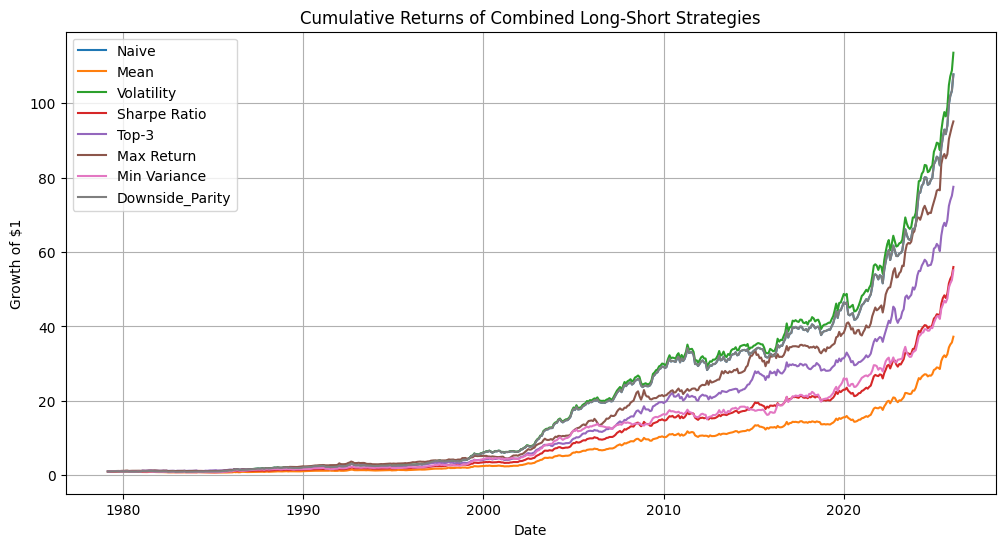

In [30]:
plt.figure(figsize=(12,6))

for col in cum_returns.columns:
    plt.plot(cum_returns.index, cum_returns[col], label=col)

plt.title("Cumulative Returns of Combined Long-Short Strategies")
plt.ylabel("Growth of $1")
plt.xlabel("Date")
plt.legend()
plt.grid(True)
plt.show()

# Exercise 2

In [31]:
import pandas as pd
import statsmodels.api as sm

# 1. Charger les données
df = pd.read_csv('../data/portfolios.csv')

# Les 30 portefeuilles vont de l'index 1 à 30 inclus
portfolio_cols = df.columns[1:31]

R = df[portfolio_cols]
factors = df[['DOL', 'CAR']]

# =====================================================================
# ÉTAPE 1 : Bêtas (Quantité de risque par portefeuille)
# =====================================================================
betas = []
for port in portfolio_cols:
    model_ts = sm.OLS(R[port], factors).fit()
    betas.append({
        'Portfolio': port,
        'Beta_DOL': model_ts.params['DOL'],
        'Beta_CAR': model_ts.params['CAR']
    })

# DataFrame des Bêtas
resultats_df = pd.DataFrame(betas).set_index('Portfolio')

# =====================================================================
# ÉTAPE 2 : Lambdas (Prix du risque du marché)
# =====================================================================
X_cs = resultats_df[['Beta_DOL', 'Beta_CAR']]
lambdas_mensuels = []

for t in range(len(df)):
    y_cs = R.iloc[t]
    model_cs = sm.OLS(y_cs, X_cs).fit()
    lambdas_mensuels.append(model_cs.params)

lambdas_df = pd.DataFrame(lambdas_mensuels, index=df['YM'])
lambdas_moyens = lambdas_df.mean()

# =====================================================================
# ÉTAPE 3 : Regrouper dans un tableau unique
# =====================================================================
# Ajout des Lambdas (identiques pour tous les portefeuilles)
resultats_df['Lambda_DOL'] = lambdas_moyens['Beta_DOL']
resultats_df['Lambda_CAR'] = lambdas_moyens['Beta_CAR']

# Calcul de la contribution de chaque facteur au rendement du portefeuille (Beta * Lambda)
resultats_df['Rendement_Attendu_DOL'] = resultats_df['Beta_DOL'] * \
    resultats_df['Lambda_DOL']
resultats_df['Rendement_Attendu_CAR'] = resultats_df['Beta_CAR'] * \
    resultats_df['Lambda_CAR']

# Rendement total attendu expliqué par le modèle
resultats_df['Rendement_Total_Attendu'] = resultats_df['Rendement_Attendu_DOL'] + \
    resultats_df['Rendement_Attendu_CAR']

# Affichage des 5 premiers portefeuilles pour vérifier
print(resultats_df.head())

# Sauvegarde des résultats dans un fichier CSV
resultats_df.to_csv('betas_et_lambdas_portfolios.csv')

           Beta_DOL  Beta_CAR  Lambda_DOL  Lambda_CAR  Rendement_Attendu_DOL  \
Portfolio                                                                      
P1CAR      1.000246 -0.390918    0.001195    0.006836               0.001195   
P2CAR      0.946753 -0.142682    0.001195    0.006836               0.001131   
P3CAR      0.997285 -0.014577    0.001195    0.006836               0.001192   
P4CAR      1.062937  0.041402    0.001195    0.006836               0.001270   
P5CAR      1.000246  0.609082    0.001195    0.006836               0.001195   

           Rendement_Attendu_CAR  Rendement_Total_Attendu  
Portfolio                                                  
P1CAR                  -0.002672                -0.001477  
P2CAR                  -0.000975                 0.000156  
P3CAR                  -0.000100                 0.001092  
P4CAR                   0.000283                 0.001553  
P5CAR                   0.004164                 0.005359  


In [32]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy import stats
from statsmodels.stats.sandwich_covariance import cov_hac

# 1. Charger les données
df = pd.read_csv('../data/portfolios.csv')
portfolio_cols = df.columns[1:31]
R = df[portfolio_cols]
factors = df[['DOL', 'CAR']]

# =====================================================================
# ÉTAPE 1 : Estimer les Bêtas (AVEC INTERCEPT)
# =====================================================================
# On ajoute une constante aux facteurs pour l'étape temporelle
X_ts = sm.add_constant(factors)
betas = []

for port in portfolio_cols:
    model_ts = sm.OLS(R[port], X_ts).fit()
    betas.append({
        'Portfolio': port,
        'Beta_DOL': model_ts.params['DOL'],
        'Beta_CAR': model_ts.params['CAR']
    })

# Créer un DataFrame pour les Bêtas
betas_df = pd.DataFrame(betas).set_index('Portfolio')

# Exporter les Bêtas modifiés (facultatif)
betas_df.to_csv('betas_portfolios_intercept.csv')

# =====================================================================
# ÉTAPE 2 : Estimer les Lambdas mensuels (AVEC INTERCEPT)
# =====================================================================
# On ajoute une constante aux Bêtas pour l'étape transversale
X_cs = sm.add_constant(betas_df[['Beta_DOL', 'Beta_CAR']])
lambdas_mensuels = []

for t in range(len(df)):
    y_cs = R.iloc[t]
    model_cs = sm.OLS(y_cs, X_cs).fit()
    lambdas_mensuels.append(model_cs.params)

# =====================================================================
# ÉTAPE 3 : Calculer Lambda, T-Stat et P-Value (Méthode Fama-MacBeth)
# =====================================================================
lambdas_mean = lambdas_df.mean()
T = len(lambdas_df)
nw_se = []

for col in lambdas_df.columns:
    ols = sm.OLS(lambdas_df[col], np.ones(T)).fit()
    nw_var = cov_hac(ols)[0, 0]
    nw_se.append(np.sqrt(nw_var))

lambdas_se = pd.Series(nw_se, index=lambdas_df.columns)
t_stats = lambdas_mean / lambdas_se
p_values = 2 * (1 - stats.t.cdf(np.abs(t_stats), df=T-1))

fm_stats = pd.DataFrame({
    'Lambda (Prix du risque)': lambdas_mean,
    'NW Std Error': lambdas_se,
    'T-stat': t_stats,
    'P-value': p_values
})

# =====================================================================
# AFFICHAGE DES RÉSULTATS
# =====================================================================
print("\n=== APERÇU DU DATAFRAME DES BÊTAS (AVEC INTERCEPT) ===")
print(betas_df)

print("\n=== STATISTIQUES DES LAMBDAS ===")
print(fm_stats)


=== APERÇU DU DATAFRAME DES BÊTAS (AVEC INTERCEPT) ===
           Beta_DOL  Beta_CAR
Portfolio                    
P1CAR      0.999662 -0.394309
P2CAR      0.947175 -0.140236
P3CAR      0.998028 -0.010262
P4CAR      1.062395  0.038260
P5CAR      0.999662  0.605691
P1VAL      1.047963 -0.136601
P2VAL      1.113137 -0.120521
P3VAL      1.016509 -0.085876
P4VAL      0.887713  0.025201
P5VAL      0.892729  0.385643
P1M1M      1.011182  0.096094
P2M1M      1.032164 -0.017702
P3M1M      1.001796 -0.049184
P4M1M      1.008871 -0.105022
P5M1M      0.947844  0.084037
P1M3M      0.996164  0.101572
P2M3M      1.035368 -0.095934
P3M3M      1.033964 -0.068680
P4M3M      1.006776 -0.051437
P5M3M      0.934730  0.128656
P1M6M      1.001307  0.087601
P2M6M      1.026113 -0.050324
P3M6M      1.079661 -0.095616
P4M6M      1.011858 -0.069496
P5M6M      0.894414  0.135475
P1M1Y      0.997273  0.090780
P2M1Y      1.037362 -0.100711
P3M1Y      1.058429 -0.086718
P4M1Y      1.039240 -0.028220
P5M1Y      0.8

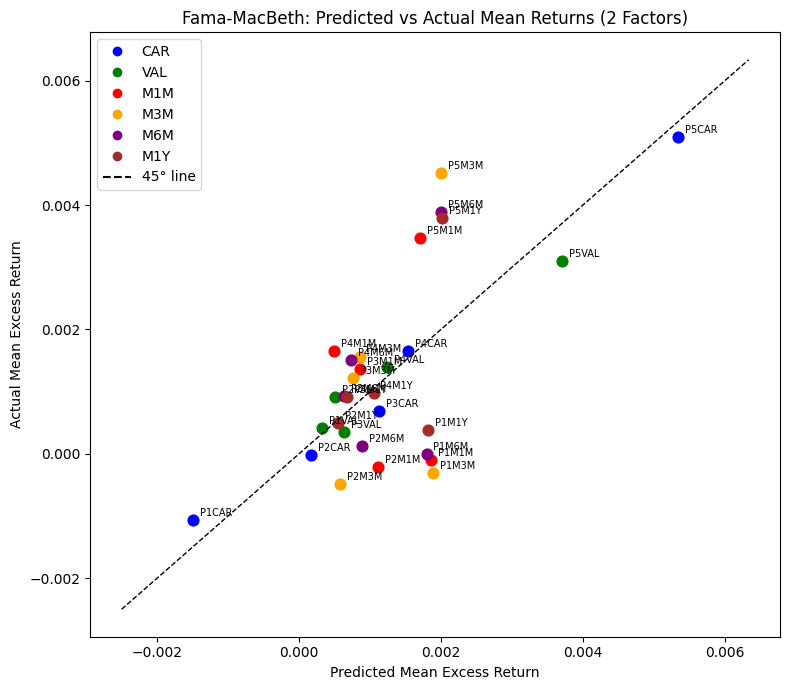

In [33]:
import matplotlib.pyplot as plt

# Actual mean returns
mean_returns = R.mean()

# Predicted returns: lambda_0 + beta_DOL * lambda_DOL + beta_CAR * lambda_CAR + beta_vol * lambda_vol
#lambda_const   = lambdas_mean['const']
lambda_DOL     = lambdas_mean['Beta_DOL']
lambda_CAR     = lambdas_mean['Beta_CAR']
#lambda_vol     = lambdas_mean['Beta_d_log_vol']

predicted = (betas_df['Beta_DOL']     * lambda_DOL
             + betas_df['Beta_CAR']     * lambda_CAR)
             #+ betas_df['Beta_d_log_vol'] * lambda_vol)

# Assign strategy labels for coloring
colors = {
    'CAR': 'blue', 'VAL': 'green',
    'M1M': 'red',  'M3M': 'orange',
    'M6M': 'purple','M1Y': 'brown'
}

fig, ax = plt.subplots(figsize=(8, 7))

for port in portfolio_cols:
    strategy = ''.join([c for c in port if not c.isdigit() and c != 'P'])[:-0 or len(port)]
    # simpler: extract suffix
    suffix = port[2:]  # e.g. 'CAR', 'VAL', 'M1M' etc.
    col = colors.get(suffix, 'black')
    ax.scatter(predicted[port], mean_returns[port], color=col, s=60)
    ax.annotate(port, (predicted[port], mean_returns[port]),
                textcoords='offset points', xytext=(5, 3), fontsize=7)

# 45-degree line
lims = [min(predicted.min(), mean_returns.min()) - 0.001,
        max(predicted.max(), mean_returns.max()) + 0.001]
ax.plot(lims, lims, 'k--', linewidth=1, label='45° line')

ax.set_xlabel('Predicted Mean Excess Return')
ax.set_ylabel('Actual Mean Excess Return')
ax.set_title('Fama-MacBeth: Predicted vs Actual Mean Returns (2 Factors)')
ax.legend(handles=[plt.Line2D([0],[0],color=v,marker='o',linestyle='',label=k)
                   for k,v in colors.items()] +
                  [plt.Line2D([0],[0],color='k',linestyle='--',label='45° line')])
plt.tight_layout()
plt.savefig('predicted_vs_actual.png', dpi=150)
plt.show()

In [34]:
# 1. Pricing errors (alphas) — should be close to zero
pricing_errors = mean_returns - predicted
print("Pricing errors:\n", pricing_errors.round(4))

# 2. Mean Absolute Pricing Error
mape = np.abs(pricing_errors).mean()
print(f"\nMean Absolute Pricing Error: {mape:.6f}")

# 3. Cross-sectional R-squared
ss_res = np.sum(pricing_errors**2)
ss_tot = np.sum((mean_returns - mean_returns.mean())**2)
r2 = 1 - ss_res / ss_tot
print(f"Cross-sectional R²: {r2:.4f}")

Pricing errors:
 P1CAR    0.0004
P2CAR   -0.0002
P3CAR   -0.0004
P4CAR    0.0001
P5CAR   -0.0002
P1VAL    0.0001
P2VAL    0.0004
P3VAL   -0.0003
P4VAL    0.0002
P5VAL   -0.0006
P1M1M   -0.0020
P2M1M   -0.0013
P3M1M    0.0005
P4M1M    0.0012
P5M1M    0.0018
P1M3M   -0.0022
P2M3M   -0.0011
P3M3M    0.0004
P4M3M    0.0007
P5M3M    0.0025
P1M6M   -0.0018
P2M6M   -0.0008
P3M6M    0.0003
P4M6M    0.0008
P5M6M    0.0019
P1M1Y   -0.0014
P2M1Y   -0.0001
P3M1Y    0.0002
P4M1Y   -0.0001
P5M1Y    0.0018
dtype: float64

Mean Absolute Pricing Error: 0.000856
Cross-sectional R²: 0.4643


In [35]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy import stats

# =====================================================================
# PRÉPARATION DES DONNÉES
# =====================================================================
# 1. Charger les données
df = pd.read_csv('../data/portfolios.csv')

# 2. Créer le nouveau facteur : première dérivée du log de la volatilité
df['d_log_vol'] = np.log(df['vol']).diff()

# 3. Supprimer la première ligne qui contient désormais un NaN (à cause du .diff)
df = df.dropna().reset_index(drop=True)

# 4. Identifier les variables
portfolio_cols = df.columns[1:31]
R = df[portfolio_cols]
factors = df[['DOL', 'CAR', 'd_log_vol']]

# =====================================================================
# ÉTAPE 1 : Séries Temporelles - Estimer les quantités de risque (Bêtas)
# =====================================================================
# On ajoute une constante (intercept) aux facteurs
X_ts = sm.add_constant(factors)
betas = []

for port in portfolio_cols:
    # Régression OLS du portefeuille sur les 3 facteurs + constante
    model_ts = sm.OLS(R[port], X_ts).fit()

    # On sauvegarde les bêtas estimés
    betas.append({
        'Portfolio': port,
        'Beta_DOL': model_ts.params['DOL'],
        'Beta_CAR': model_ts.params['CAR'],
        'Beta_d_log_vol': model_ts.params['d_log_vol']
    })

# Création du DataFrame des Bêtas
betas_df = pd.DataFrame(betas).set_index('Portfolio')

# Sauvegarde des bêtas dans un fichier CSV (optionnel)
betas_df.to_csv('betas_portfolios_3_factors.csv')

# =====================================================================
# ÉTAPE 2 : Transversale - Estimer les prix du risque (Lambdas)
# =====================================================================
# On ajoute une constante (intercept) aux Bêtas pour la seconde étape
X_cs = sm.add_constant(betas_df[['Beta_DOL', 'Beta_CAR', 'Beta_d_log_vol']])
lambdas_mensuels = []

for t in range(len(df)):
    y_cs = R.iloc[t]
    model_cs = sm.OLS(y_cs, X_cs).fit()
    lambdas_mensuels.append(model_cs.params)

# Création du DataFrame des Lambdas indexé par le temps
lambdas_df = pd.DataFrame(lambdas_mensuels, index=df['YM'])
T = len(lambdas_df)
# =====================================================================
# ÉTAPE 3 : Statistiques Fama-MacBeth (Significativité)
# =====================================================================
lambdas_mean = lambdas_df.mean()
nw_se = []

for col in lambdas_df.columns:
    ols = sm.OLS(lambdas_df[col], np.ones(T)).fit()
    nw_var = cov_hac(ols)[0, 0]
    nw_se.append(np.sqrt(nw_var))

lambdas_se = pd.Series(nw_se, index=lambdas_df.columns)
t_stats = lambdas_mean / lambdas_se
p_values = 2 * (1 - stats.t.cdf(np.abs(t_stats), df=T-1))

fm_stats = pd.DataFrame({
    'Lambda (Prix du risque)': lambdas_mean,
    'NW Std Error': lambdas_se,
    'T-stat': t_stats,
    'P-value': p_values
})

# =====================================================================
# AFFICHAGE DES RÉSULTATS
# =====================================================================
print("=== APERÇU DES BÊTAS (Les 5 premiers) ===")
print(betas_df)

print("\n=== NOUVELLES STATISTIQUES DES LAMBDAS (3 FACTEURS + INTERCEPT) ===")
print(fm_stats)

=== APERÇU DES BÊTAS (Les 5 premiers) ===
           Beta_DOL  Beta_CAR  Beta_d_log_vol
Portfolio                                    
P1CAR      0.999091 -0.398107       -0.000178
P2CAR      0.948447 -0.137830        0.001066
P3CAR      1.002454  0.003466        0.003113
P4CAR      1.057749  0.027899       -0.003718
P5CAR      0.999091  0.601893       -0.000178
P1VAL      1.049092 -0.133387        0.000826
P2VAL      1.117203 -0.110437        0.003140
P3VAL      1.017399 -0.083457        0.000664
P4VAL      0.882886  0.004524       -0.002764
P5VAL      0.890872  0.387471       -0.002148
P1M1M      1.005369  0.078987       -0.004192
P2M1M      1.027095 -0.030843       -0.003853
P3M1M      1.008103 -0.032884        0.004799
P4M1M      1.018385 -0.081537        0.007361
P5M1M      0.943418  0.076847       -0.003838
P1M3M      0.993723  0.098011       -0.002162
P2M3M      1.035198 -0.095924       -0.000179
P3M3M      1.038881 -0.060882        0.004285
P4M3M      1.009695 -0.044612        0

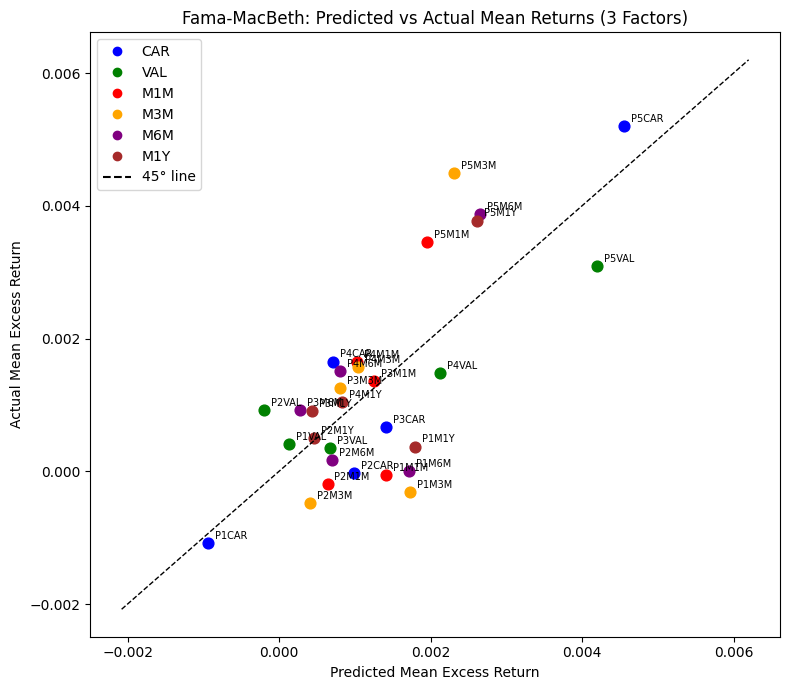

In [36]:
import matplotlib.pyplot as plt

# Actual mean returns
mean_returns = R.mean()

# Predicted returns: lambda_0 + beta_DOL * lambda_DOL + beta_CAR * lambda_CAR + beta_vol * lambda_vol
lambda_const   = lambdas_mean['const']
lambda_DOL     = lambdas_mean['Beta_DOL']
lambda_CAR     = lambdas_mean['Beta_CAR']
lambda_vol     = lambdas_mean['Beta_d_log_vol']

predicted = (lambda_const
             + betas_df['Beta_DOL']     * lambda_DOL
             + betas_df['Beta_CAR']     * lambda_CAR
             + betas_df['Beta_d_log_vol'] * lambda_vol)

# Assign strategy labels for coloring
colors = {
    'CAR': 'blue', 'VAL': 'green',
    'M1M': 'red',  'M3M': 'orange',
    'M6M': 'purple','M1Y': 'brown'
}

fig, ax = plt.subplots(figsize=(8, 7))

for port in portfolio_cols:
    strategy = ''.join([c for c in port if not c.isdigit() and c != 'P'])[:-0 or len(port)]
    # simpler: extract suffix
    suffix = port[2:]  # e.g. 'CAR', 'VAL', 'M1M' etc.
    col = colors.get(suffix, 'black')
    ax.scatter(predicted[port], mean_returns[port], color=col, s=60)
    ax.annotate(port, (predicted[port], mean_returns[port]),
                textcoords='offset points', xytext=(5, 3), fontsize=7)

# 45-degree line
lims = [min(predicted.min(), mean_returns.min()) - 0.001,
        max(predicted.max(), mean_returns.max()) + 0.001]
ax.plot(lims, lims, 'k--', linewidth=1, label='45° line')

ax.set_xlabel('Predicted Mean Excess Return')
ax.set_ylabel('Actual Mean Excess Return')
ax.set_title('Fama-MacBeth: Predicted vs Actual Mean Returns (3 Factors)')
ax.legend(handles=[plt.Line2D([0],[0],color=v,marker='o',linestyle='',label=k)
                   for k,v in colors.items()] +
                  [plt.Line2D([0],[0],color='k',linestyle='--',label='45° line')])
plt.tight_layout()
plt.savefig('predicted_vs_actual.png', dpi=150)
plt.show()

In [37]:
# 1. Pricing errors (alphas) — should be close to zero
pricing_errors = mean_returns - predicted
print("Pricing errors:\n", pricing_errors.round(4))

# 2. Mean Absolute Pricing Error
mape = np.abs(pricing_errors).mean()
print(f"\nMean Absolute Pricing Error: {mape:.6f}")

# 3. Cross-sectional R-squared
ss_res = np.sum(pricing_errors**2)
ss_tot = np.sum((mean_returns - mean_returns.mean())**2)
r2 = 1 - ss_res / ss_tot
print(f"Cross-sectional R²: {r2:.4f}")

Pricing errors:
 P1CAR   -0.0001
P2CAR   -0.0010
P3CAR   -0.0007
P4CAR    0.0009
P5CAR    0.0006
P1VAL    0.0003
P2VAL    0.0011
P3VAL   -0.0003
P4VAL   -0.0006
P5VAL   -0.0011
P1M1M   -0.0015
P2M1M   -0.0008
P3M1M    0.0001
P4M1M    0.0006
P5M1M    0.0015
P1M3M   -0.0020
P2M3M   -0.0009
P3M3M    0.0005
P4M3M    0.0005
P5M3M    0.0022
P1M6M   -0.0017
P2M6M   -0.0005
P3M6M    0.0007
P4M6M    0.0007
P5M6M    0.0012
P1M1Y   -0.0014
P2M1Y    0.0000
P3M1Y    0.0005
P4M1Y    0.0002
P5M1Y    0.0012
dtype: float64

Mean Absolute Pricing Error: 0.000858
Cross-sectional R²: 0.5621
